In [14]:
# Rahil Kumar
# 18-3-2025
# Code for backtesting a simple moving average strategy on a BTC/USD dataset

# Step 1 --> Import the libraries using below code
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# Step 2 --> Import the dataset
df = pd.read_csv("AP_dataset.csv")

In [16]:
# Step 3 --> Check the 5 rows of the dataset to know the structure of the dataset
df.sample(5)

,UNIT,TIMESTAMP,TYPE,MARKET,INSTRUMENT,MAPPED_INSTRUMENT,BASE,QUOTE,BASE_ID,QUOTE_ID,...,TOTAL_TRADES_UNKNOWN,VOLUME,QUOTE_VOLUME,VOLUME_BUY,QUOTE_VOLUME_BUY,VOLUME_SELL,QUOTE_VOLUME_SELL,VOLUME_UNKNOWN,QUOTE_VOLUME_UNKNOWN,time
222286,MINUTE,1735687620,954,binance,BTCUSDT,BTC-USDT,BTC,USDT,1,7,...,0,1.52041,1.424951e+05,1.34491,1.260474e+05,0.17550,1.644770e+04,0,0,12/31/2024 23:27
89279,MINUTE,1727707200,954,binance,BTCUSDT,BTC-USDT,BTC,USDT,1,7,...,0,24.91544,1.594232e+06,18.55165,1.187115e+06,6.36379,4.071177e+05,0,0,9/30/2024 14:40
164588,MINUTE,1732225740,954,binance,BTCUSDT,BTC-USDT,BTC,USDT,1,7,...,0,30.79268,3.007605e+06,7.40653,7.233865e+05,23.38615,2.284218e+06,0,0,11/21/2024 21:49
194370,MINUTE,1734012660,954,binance,BTCUSDT,BTC-USDT,BTC,USDT,1,7,...,0,13.05060,1.319204e+06,4.83839,4.890590e+05,8.21221,8.301447e+05,0,0,12/12/2024 14:11
228293,MINUTE,1736048040,954,binance,BTCUSDT,BTC-USDT,BTC,USDT,1,7,...,0,1.26313,1.239565e+05,0.96455,9.465481e+04,0.29858,2.930170e+04,0,0,1/5/2025 3:34


In [17]:
# Step 4 --> Convert timestamp to datetime
df['time'] = pd.to_datetime(df['time'])

In [18]:
# Step 5 --> Define Moving Averages
df['SMA_10'] = df['CLOSE'].rolling(window=10).mean()
df['SMA_50'] = df['CLOSE'].rolling(window=50).mean()

In [19]:
# Step 6 --> Based on Moving avergaes generate buy/sell signals
df['Signal'] = 0
df.loc[df['SMA_10'] > df['SMA_50'], 'Signal'] = 1  # Buy Signal
df.loc[df['SMA_10'] < df['SMA_50'], 'Signal'] = -1 # Sell Signal

In [20]:
# Step 7 --> Find trade entries and exits
df['Position'] = df['Signal'].diff()
trades = df[(df['Position'] == 2) | (df['Position'] == -2)]  # Explicitly capture buy-to-sell and sell-to-buy transitions

In [21]:
# Step 8 --> Initialize the Backtest variables
initial_capital = 10000
capital = initial_capital
trade_log = []
position = None
entry_price = 0

In [ ]:
# Step 9 --> Simulate trading
def backtest():
    global capital, position, entry_price
    for _, row in trades.iterrows():
        if row['Signal'] == 1 and position is None:  # Buy
            position = capital / row['CLOSE']  # Buy with full capital
            entry_price = row['CLOSE']
        elif row['Signal'] == -1 and position is not None:  # Sell
            exit_price = row['CLOSE']
            pnl = (exit_price - entry_price) * position
            capital += pnl  # Update capital
            trade_log.append([row['time'], entry_price, exit_price, pnl, capital])
            position = None  # Close position

backtest()

In [23]:
# Convert trade log to DataFrame
trade_df = pd.DataFrame(trade_log, columns=['Exit Time', 'Entry Price', 'Exit Price', 'PNL', 'Capital'])

In [24]:
# Calculate performance metrics
total_pnl = capital - initial_capital
max_drawdown = (trade_df['Capital'].max() - trade_df['Capital'].min()) / trade_df['Capital'].max() * 100
win_rate = (trade_df['PNL'] > 0).mean() * 100

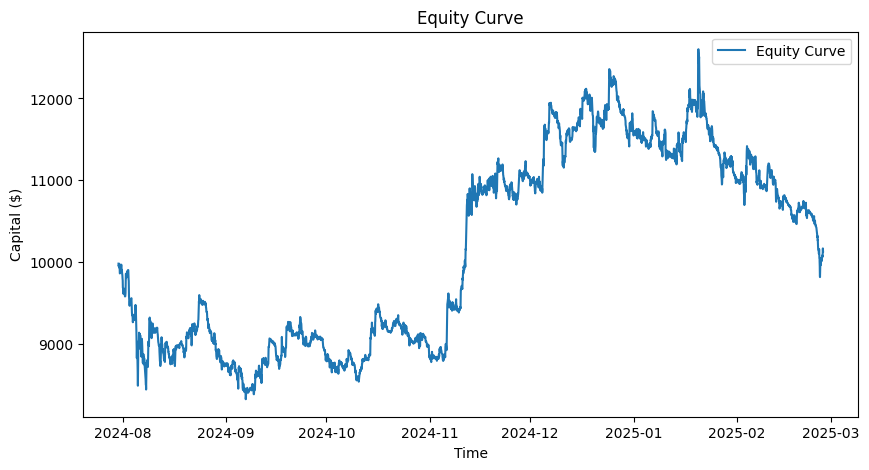

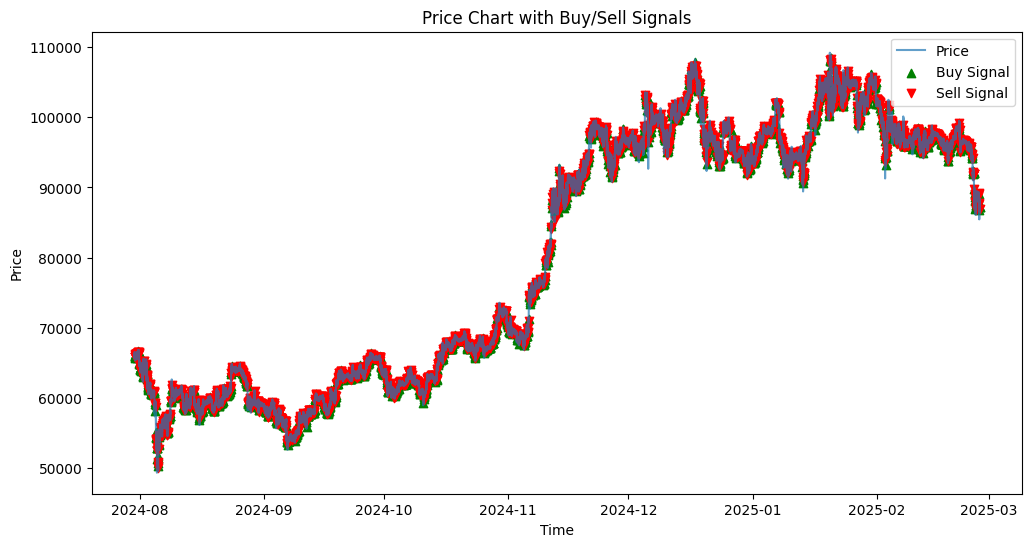

Total PNL: $131.71
Max Drawdown: 33.93%
Win Rate: 33.50%


In [25]:
# Plot Equity Curve
plt.figure(figsize=(10,5))
plt.plot(trade_df['Exit Time'], trade_df['Capital'], label='Equity Curve')
plt.xlabel('Time')
plt.ylabel('Capital ($)')
plt.title('Equity Curve')
plt.legend()
plt.show()

# Plot Buy/Sell signals on price chart
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['CLOSE'], label='Price', alpha=0.7)
plt.scatter(df.loc[df['Position'] == 2, 'time'], df.loc[df['Position'] == 2, 'CLOSE'], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(df.loc[df['Position'] == -2, 'time'], df.loc[df['Position'] == -2, 'CLOSE'], marker='v', color='r', label='Sell Signal', alpha=1)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Chart with Buy/Sell Signals')
plt.legend()
plt.show()
# Print results
print(f'Total PNL: ${total_pnl:.2f}')
print(f'Max Drawdown: {max_drawdown:.2f}%')
print(f'Win Rate: {win_rate:.2f}%')